In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np


msa_file = '../urban_greening/msa/michiganMSA_reprojected.shp'
gpp_file = "../urban_greening/nov.15/michigan_test/modis-250-gpp-2015001.tif"
nlcd_file = "../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img"
ua_file = "../urban_greening/gis_processed/ua/ua_30.tif"


msa=gpd.read_file(msa_file)
msa=msa[msa['NAMELSAD']=='Grand Rapids-Wyoming-Kentwood, MI Metro Area'] # Subsetting to my AOI


In [2]:
nee_file = "../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc"

info = nee_file.split('/')[-1].split('.')
var_name = info[0]
ML_method = info[3]
year = info[7]
partitioning_method = info[2]

import xarray as xr
nee_ds = xr.open_dataset(nee_file)
# calc transform for this resolution, given the data is worldwide (the original metadata is incorrect)
minx, miny, maxx, maxy = -180.0, -90.0, 180.0, 90.0
resolution_x = 360 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[0])
resolution_y = 180 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[1])
nee_transform = rasterio.transform.from_origin(minx, maxy, resolution_x, resolution_y)


In [45]:
import geopandas as gpd
from shapely.geometry import mapping
import xarray as xr

gdf = gpd.read_file(msa_file)
ds = xr.open_dataset(nee_file)
# gdf = gdf.to_crs(ds.rio.crs)
ds = ds.rio.write_crs("EPSG:4326")
clipped_ds = ds.rio.clip(msa.geometry.apply(mapping), gdf.crs)


In [ ]:
# write a nee month all us to tiff
nee_month_us = 'nee.tif'
ds['NEE'][0].rio.write_crs('EPSG:4326', inplace=True)
ds['NEE'][0].rio.write_transform(nee_transform, inplace=True)

ds['NEE'][0].rio.to_raster()


In [47]:
nee_dstrd.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]')

In [ ]:
import numpy as np
with rasterio.open(nee_month_us) as nee_dstrd:
    Vector=msa.to_crs('EPSG:4326')
    msa_crs = Vector.crs
    gpp_crs = nee_dstrd.crs

    nee_clip_image, nee_clip_transform=mask(nee_dstrd,msa.geometry,crop=True)

    tiff_file = "gpp_msa_rr_beforefillnearestfloatwithnan.tif"

    with rasterio.open(tiff_file) as gpp_rr:
        from rasterio.enums import Resampling
        from rasterio.warp import calculate_default_transform, reproject
        nee_msa_fine = np.empty((gpp_rr.shape[0], gpp_rr.shape[1]), dtype=np.float32) #make it support nan
        reproject(
            source=nee_clip_image,
            destination=nee_msa_fine,
            src_transform=nee_clip_transform,
            src_crs='EPSG:4326',
            dst_transform=gpp_rr.transform,
            dst_crs=gpp_rr.crs,
            resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            src_nodata=np.nan
        )

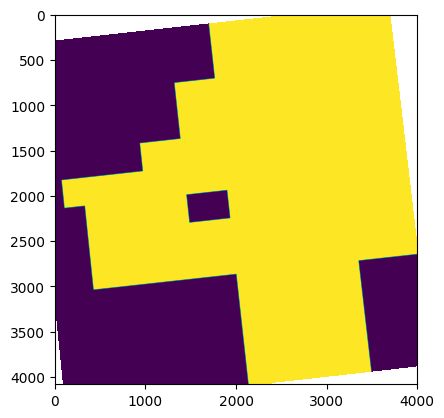

<Axes: >

In [40]:
rasterio.plot.show(nee_msa_fine)

In [ ]:
nee_clip_image.shape

(4081, 4001)

In [57]:
# Metadata for the output TIFF
output_path = "nee_clip_image.tiff"
output_file = nee_clip_image[0]
# Write the ndarray to a GeoTIFF
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=output_file.shape[0],
    width=output_file.shape[1],
    count=1,  # Number of bands
    dtype=output_file.dtype,
    crs=gpp_rr.crs,
    transform=gpp_rr.transform,
    # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
) as dst:
    # Write data to the first band
    dst.write(output_file, 1)

print(f"GeoTIFF saved to {output_path}")

GeoTIFF saved to nee_clip_image.tiff


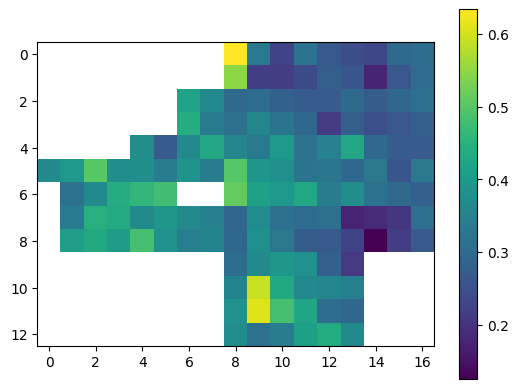

In [4]:
import matplotlib.pyplot as plt

nee_month = clipped_ds['NEE'][0]
plt.imshow(nee_month)
plt.colorbar()

In [5]:
tiff_file = "gpp_msa_rr_beforefillnearestfloatwithnan.tif"
with rasterio.open(tiff_file) as gpp_rr:
    target_crs = gpp_rr.crs
    target_resolution = gpp_rr.res  # Resolution in units of the CRS
    target_bounds = gpp_rr.bounds  # Spatial extent of the GeoTIFF
    target_transform = gpp_rr.transform  # Affine transform
    target_shape = gpp_rr.shape  # Height and width of the GeoTIFF

In [32]:
target_transform

Affine(30.0, 0.0, 786105.0,
       0.0, -30.0, 2327445.0)

In [6]:
from rasterio.enums import Resampling

nee_month = nee_month.rio.write_crs("EPSG:4326") 

reprojected_nee_month = nee_month.rio.reproject(
    target_crs.to_string(),
    shape=target_shape,
    **{"dst_bounds": target_bounds},  # Match the spatial extent
    resampling=Resampling.nearest
)
reprojected_nee_month.shape

(4081, 4001)

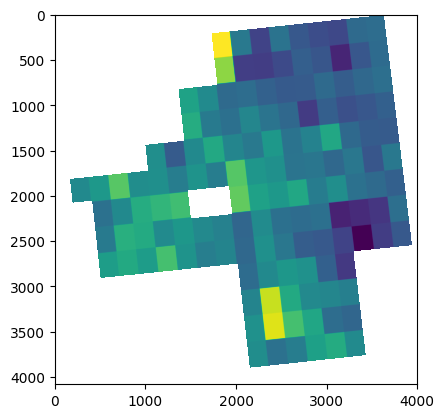

<Axes: >

In [8]:
import rasterio.plot
rasterio.plot.show(reprojected_nee_month)

In [136]:
# Metadata for the output TIFF
output_path = "resampledneenearest.tiff"

# Write the ndarray to a GeoTIFF
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=reprojected_nee_month.shape[0],
    width=reprojected_nee_month.shape[1],
    count=1,  # Number of bands
    dtype=reprojected_nee_month.dtype,
    crs=target_crs,
    transform=target_transform,
    # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
) as dst:
    # Write data to the first band
    dst.write(reprojected_nee_month, 1)

print(f"GeoTIFF saved to {output_path}")

GeoTIFF saved to resampledneenearest.tiff


In [9]:

with rasterio.open(tiff_file) as gpp_msa:
    # rasterio.plot.show(gpp_msa)
    print(gpp_msa.read(1).shape)
    x = reprojected_nee_month / gpp_msa.read(1)

(4081, 4001)


In [12]:
gpp_crs

NameError: name 'gpp_crs' is not defined

In [ ]:
from import CRS
with rasterio.open(tiff_file) as gpp_msa:
    reprojected_gpp = gpp_msa.rio.reproject(
        # CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
        'EPSG:4326',
        shape=nee_month.shape,
        **{"dst_bounds": target_bounds},  # Match the spatial extent
        resampling=Resampling.nearest
    )
reprojected_nee_month.shape